# Movie Recommendation by prediction of customer rating for a movie

# Introduction: 

Goal : Finding customer rating for movies using truncated SVD.

Here basic python libraries like numpy, pandas and scipy are only used to understand the algorithm better.

Consider we have input information of customer rating given by different users for different movies.
We can predict the customer rating of a user for a movie that he /she has not rated yet and thereby recommend them new movies.

Since input information (utility matrix) is a sparse matrix, SVD can be used to decompose the user-movie interaction.
Here features are selected based on the RMSE function.
For the feature 12, it was found that the RMSE value is minimum and hence SVD with features 12 has been used.

Inspired from Netflix competition, https://towardsdatascience.com/the-netflix-prize-how-even-ai-leaders-can-trip-up-5c1f38e95c9f

Credits to 
1. https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65 for the reference on the code.
2. https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e for the reference on the dataset

**Author:** Akshaya Ravi, **Date:** 11/10/2020


In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm

In [3]:
df_movieinput = pd.read_csv("Movies.csv",delimiter=';')

C:\Users\20204321\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (25,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df_userrating = pd.read_csv("Ratings_small.csv",delimiter=';')

In [5]:
df_userrating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
df_userrating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
df= df_userrating #Renaming for easier use
df['userId'] = df['userId'].astype('str')
df['movieId'] = df['movieId'].astype('str')
users = df['userId'].unique() #list of all users
movies = df['movieId'].unique() #list of all moviesprint("Number of users", len(users))
print("Number of users", len(users))
print("Number of movies", len(movies))
print(df.head())

Number of users 671
Number of movies 9066
  userId movieId  rating   timestamp
0      1      31     2.5  1260759144
1      1    1029     3.0  1260759179
2      1    1061     3.0  1260759182
3      1    1129     2.0  1260759185
4      1    1172     4.0  1260759205


In [8]:
test = pd.DataFrame(columns=df.columns)
train = pd.DataFrame(columns=df.columns)
test_ratio = 0.2 #fraction of data to be used as test set.
for u in users:
    temp = df[df['userId'] == u]
    n = len(temp)
    test_size = int(test_ratio*n)
    temp = temp.sort_values('timestamp').reset_index()
    temp.drop('index', axis=1, inplace=True)
    dummy_test = temp.iloc[test_size:]
    dummy_train = temp.iloc[:-(n-test_size)]
    test = pd.concat([test, dummy_test])
    train = pd.concat([train, dummy_train])

In [9]:
# test.head()
print(test.shape)
print(train.shape)
print(df.shape) # Original shape is retained after test and train split

(80251, 4)
(19753, 4)
(100004, 4)


In [10]:
train.head()

,userId,movieId,rating,timestamp
0,1,2294,2.0,1260759108
1,1,2455,2.5,1260759113
2,1,3671,3.0,1260759117
3,1,1339,3.5,1260759125
0,2,296,4.0,835355395


In [11]:
test.head()

,userId,movieId,rating,timestamp
4,1,1343,2.0,1260759131
5,1,1371,2.5,1260759135
6,1,2105,4.0,1260759139
7,1,31,2.5,1260759144
8,1,1293,2.0,1260759148


In [12]:
def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):   
    """
        :param data:      Array-like, 2D, nx3
        :param formatizer:pass the formatizer
        :return:          utility matrix (n x m), n=users, m=items
    """
        
    itemField = formatizer['item']
    userField = formatizer['user']
    valueField = formatizer['value']    
    
    userList = data.iloc[:,userField].tolist()
    itemList = data.iloc[:,itemField].tolist()
    valueList = data.iloc[:,valueField].tolist()    
    
    users = list(set(data.iloc[:,userField]))
    items = list(set(data.iloc[:,itemField]))    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [np.nan for i in range(len(users))] 
               for item in items}    
    for i in range(0,len(data)):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value   
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    # users_index gives us a mapping of user_id to index of user
    # items_index provides the same for items    
    return X, users_index, items_index

In [13]:
X,user_index,items_index= create_utility_matrix(train)

In [14]:
X.shape
print(train.userId.nunique())
print(train.movieId.nunique())
print(test.userId.nunique())
print(test.movieId.nunique())

671
3886
671
8733


In [15]:
def svd(train, k):
    utilMat = np.array(train)    # the nan or unavailable entries are masked
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)  
    x = np.tile(item_means, (utilMat.shape[0],1))    
    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    utilMat = utilMat - x    
# The magic happens here. U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    
    s=np.diag(s)    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]    
    s_root=sqrtm(s)    
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)    
    UsV = UsV + x    
    print("svd done")
    print("The shape of the matrix from SVD is",UsV.shape)
    return UsV

In [16]:
#Calculating rmse value
def rmse(true, pred):
    # this will be used towards the end
    x = true - pred
    return sum([xi*xi for xi in x])/len(x)

# to test the performance over a different number of features
# Selecting the singular values with respect to highest importance 
# found by the SVD decomposition
no_of_features = [8,10,12,13,14,17] #hyperparameter
utilMat, users_index, items_index = create_utility_matrix(train)
rmse_features = []
#Iterating for each feature
for f in no_of_features: 
    svdout = svd(utilMat, k=f)
    pred = [] 
    #to store the predicted ratings for each user in test data   
    for _,row in test.iterrows():
        user = row['userId']
        item = row['movieId']        
        u_index = users_index[user] 
        # test data contains the user already foreseen from training data, cold start probelme is not addressed
        if item in items_index:
            i_index = items_index[item]
            pred_rating = svdout[u_index, i_index]  #calls the utility matrix found from SVD
        else:
            pred_rating = np.mean(svdout[u_index, :]) # When certain item or movie is not found from training,
                                                     # mean rating over that user is taken 
        pred.append(pred_rating)
    a=rmse(test['rating'], pred)
    print("RMSE value of feature value {} is {}".format(f,a))
    rmse_features.append(a)

svd done
The shape of the matrix from SVD is (671, 3886)
RMSE value of feature value 8 is 1.1363192568543867
svd done
The shape of the matrix from SVD is (671, 3886)
RMSE value of feature value 10 is 1.136489403342238
svd done
The shape of the matrix from SVD is (671, 3886)
RMSE value of feature value 12 is 1.1364317334528875
svd done
The shape of the matrix from SVD is (671, 3886)
RMSE value of feature value 13 is 1.1365229608454714
svd done
The shape of the matrix from SVD is (671, 3886)
RMSE value of feature value 14 is 1.1370702442273102
svd done
The shape of the matrix from SVD is (671, 3886)
RMSE value of feature value 17 is 1.1379467661294826


Text(0.5, 1.0, 'Prediction error of customer rating across different features')

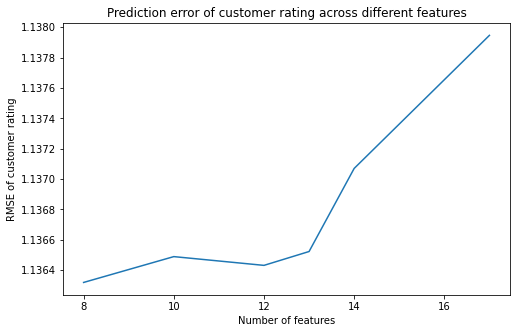

In [25]:
import matplotlib.pyplot as plt
plt.plot(no_of_features,rmse_features)
plt.rcParams["figure.figsize"] = (6,5)
plt.xlabel('Number of features')
plt.ylabel('RMSE of customer rating')
plt.title('Prediction error of customer rating across different features')

In [18]:
#selecting feature value as 12 based on RMSE
svdout = svd(utilMat, k=12)
pred = [] 
    #to store the predicted ratings for each user in test data   
for _,row in test.iterrows():
    user = row['userId']
    item = row['movieId']        
    u_index = users_index[user] 
        # test data contains the user already foreseen from training data, cold start probelme is not addressed
    if item in items_index:
        i_index = items_index[item]
        pred_rating = svdout[u_index, i_index]  #calls the utility matrix found from SVD
    else:
        pred_rating = np.mean(svdout[u_index, :]) # When certain item or movie is not found from training,
                                                     # mean rating over that user is taken 
    pred.append(pred_rating) #prediction for test data is stored in pred

svd done
The shape of the matrix from SVD is (671, 3886)


In [19]:
#Checking if it works for random movie id
train.head()
test.shape
new_index=pd.Series(np.arange(0,80251,1))
test.set_index(new_index)
predicted_rating = pred[25]
original_rating = test.iloc[25,2]
print("predicted is", predicted_rating)
print("original is", original_rating)

predicted is 4.3644602712160605
original is 4.0
